In [1]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 757664362607731550
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12350384263172757513
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2530905091445659276
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9949574592
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11229361920064317527
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [4]:
import os
import math
import pandas as pd
import matplotlib.image as img
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [5]:
tf.__version__

'2.3.1'

In [6]:
# return gray image
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [7]:
# training targets, you can use your custome csv file if you already created it with "training-sample.py"
targets = pd.read_csv('data_csv/jester-v1-train.csv', header=None, sep = ";", index_col=0)

# validation targets, you can use your custome csv file if you already created it with "validation-sample.py"
targets_validation = pd.read_csv('data_csv/jester-v1-validation.csv', header=None, sep = ";", index_col=0)


In [8]:
targets_validation

,1
0,
9223,Thumb Up
107090,Pushing Two Fingers Away
42920,Swiping Left
106485,Thumb Down
142201,Rolling Hand Backward
...,...
97044,Drumming Fingers
136208,Sliding Two Fingers Right
12180,Rolling Hand Backward


In [9]:
targets

,1
0,
34870,Drumming Fingers
56557,Sliding Two Fingers Right
129112,Sliding Two Fingers Down
63861,Pulling Two Fingers In
131717,Sliding Two Fingers Up
...,...
75507,Swiping Down
48433,Sliding Two Fingers Left
146421,Sliding Two Fingers Right


In [10]:
targets = targets.to_dict()[1]

In [11]:
len(targets)

118562

In [12]:
targets[100000]

'Thumb Up'

In [13]:
target_names = pd.read_csv('./data_csv/jester-v1-labels.csv', header=None)
target_names = target_names.to_dict()[0]
len(target_names)

27

In [14]:
target_names

{0: 'Swiping Left',
 1: 'Swiping Right',
 2: 'Swiping Down',
 3: 'Swiping Up',
 4: 'Pushing Hand Away',
 5: 'Pulling Hand In',
 6: 'Sliding Two Fingers Left',
 7: 'Sliding Two Fingers Right',
 8: 'Sliding Two Fingers Down',
 9: 'Sliding Two Fingers Up',
 10: 'Pushing Two Fingers Away',
 11: 'Pulling Two Fingers In',
 12: 'Rolling Hand Forward',
 13: 'Rolling Hand Backward',
 14: 'Turning Hand Clockwise',
 15: 'Turning Hand Counterclockwise',
 16: 'Zooming In With Full Hand',
 17: 'Zooming Out With Full Hand',
 18: 'Zooming In With Two Fingers',
 19: 'Zooming Out With Two Fingers',
 20: 'Thumb Up',
 21: 'Thumb Down',
 22: 'Shaking Hand',
 23: 'Stop Sign',
 24: 'Drumming Fingers',
 25: 'No gesture',
 26: 'Doing other things'}

In [15]:
# Get the data directories
training_path = "./datasets/train/"
validation_path = "./datasets/val/"

train_dirs = os.listdir(training_path)
val_dirs = os.listdir(validation_path)

In [16]:
'''
The videos do not have the same number of frames, here we try to unify.
'''
hm_frames = 30 # number of frames
# unify number of frames for each training
def get_unify_frames(path):
    offset = 0
    # pick frames
    frames = os.listdir(path)
    frames_count = len(frames)
    # unify number of frames 
    if hm_frames > frames_count:
        # duplicate last frame if video is shorter than necessary
        frames += [frames[-1]] * (hm_frames - frames_count)
    elif hm_frames < frames_count:
        # If there are more frames, then sample starting offset
        frames = frames[0:hm_frames]
    return frames  

## Preprocess the data

In [17]:
scaler = StandardScaler()

def generator(dataset, batch_size=64):
    path = './datasets/'+dataset+'/'
    dirs = os.listdir(path)
    
    while True:
        batch_dirs = np.random.choice(dirs, size=batch_size)

        batch_x = []
        batch_y = []

        for d in batch_dirs:
            unify_frames = get_unify_frames(path+d)
            frames = [cv2.imread(path+d+'/'+f, cv2.IMREAD_GRAYSCALE) for f in unify_frames]
            frames = [cv2.resize(frame, (132, 100)) for frame in frames]
            frames = np.array(frames)

            label = targets[int(d)]
            labels = np.zeros(len(target_names))
            index = list(target_names.values()).index(label)
            labels[index] = 1

            batch_x.append(frames)
            batch_y.append(labels)
        
        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        
        batch_x = scaler.fit_transform(batch_x.reshape(-1, 30*132*100))
        batch_x = batch_x.reshape(-1, 30, 132, 100, 1)
        
        yield batch_x, batch_y

In [18]:
for batch_x, batch_y in generator('train', batch_size=64):
    print(len(batch_x), len(batch_y))
    print(len(batch_x[0]), len(batch_y[0]))
    print(batch_x.shape, batch_y.shape)
    break

64 64
30 27
(64, 30, 132, 100, 1) (64, 27)


In [19]:
train_generator = generator('train', batch_size=64)
validation_generator = generator('val', batch_size=64)

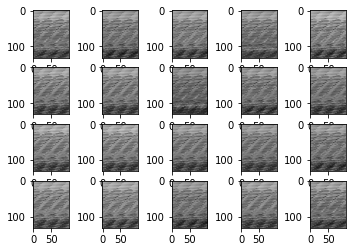

In [20]:
fig = plt.figure()
for batches in train_generator:
    for batch_frames in batches:
        for frames in batch_frames:
            i = 0
            for frame in frames[:20]:
                i += 1
                fig.add_subplot(4, 5, i)
                plt.imshow(frame, cmap='gray')
            break
        break
    break
plt.show()

In [21]:
# My model
class Conv3DModel(tf.keras.Model):
  def __init__(self):
    super(Conv3DModel, self).__init__()
    # Convolutions
    self.conv1 = tf.compat.v2.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', name="conv1", data_format='channels_last')
    self.pool1 = tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2), data_format='channels_last')
    self.conv2 = tf.compat.v2.keras.layers.Conv3D(64, (3, 3, 3), activation='relu', name="conv1", data_format='channels_last')
    self.pool2 = tf.keras.layers.MaxPool3D(pool_size=(2, 2,2), data_format='channels_last')
   
    # LSTM & Flatten
    self.convLSTM =tf.keras.layers.ConvLSTM2D(40, (3, 3))
    self.flatten =  tf.keras.layers.Flatten(name="flatten")

    # Dense layers
    self.d1 = tf.keras.layers.Dense(128, activation='relu', name="d1")
    self.out = tf.keras.layers.Dense(27, activation='softmax', name="output")

  def call(self, x):
    x = self.conv1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.pool2(x)
    x = self.convLSTM(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.out(x)

## 1. the simplest method with beginner syntax

In [22]:
model = Conv3DModel()

In [26]:
# choose the loss and optimizer methods
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

In [28]:
# Run the training 
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=118_000//64,
                    validation_steps=14_000/64,
                    epochs=10)

Epoch 1/10


ResourceExhaustedError:  OOM when allocating tensor with shape[64,32,28,130,98] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/conv3d_model/max_pooling3d/MaxPool3D/MaxPool3DGrad (defined at <ipython-input-28-d8afea8162a9>:2) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_7718]

Errors may have originated from an input operation.
Input Source operations connected to node gradient_tape/conv3d_model/max_pooling3d/MaxPool3D/MaxPool3DGrad:
 conv3d_model/conv1/Relu (defined at <ipython-input-21-471f12822d66>:20)	
 conv3d_model/max_pooling3d/MaxPool3D (defined at <ipython-input-21-471f12822d66>:21)

Function call stack:
train_function


In [ ]:
# just after one epoch
history.history

In [ ]:
# save the model for use in the application
model.save_weights('weights/path_to_my_weights', save_format='tf')